# Perform POD of data that is in disk

For this example we do not include the data in the repository.

So please, work with your own data and experiment!

We do show the general process to follow.

Note that you should check the input.json file to change some of the configuration.

You do not need to do that of course. You can also modify the values directly in this notebook.

In [4]:
import json
import numpy as np

# Import MPI
from mpi4py import MPI #equivalent to the use of MPI_init() in C

# Split communicator for MPI - MPMD
worldcomm = MPI.COMM_WORLD
worldrank = worldcomm.Get_rank()
worldsize = worldcomm.Get_size()
col = 1
comm = worldcomm.Split(col,worldrank)
rank = comm.Get_rank()
size = comm.Get_size()

Read the input file

In [5]:
# Open input file to see path
f = open ("inputs.json", "r") 
params_file = json.loads(f.read())
f.close()

# Read the POD inputs
pod_number_of_snapshots = params_file["number_of_snapshots"]
pod_fields = params_file["fields"]
number_of_pod_fields = len(pod_fields)
pod_batch_size = params_file["batch_size"]
pod_keep_modes = params_file["keep_modes"]
pod_write_modes = params_file["write_modes"]



Import pynektools functions

In [6]:
# Import IO helper functions
from pynektools.io.utils import get_fld_from_ndarray, io_path_data

# Import modules for reading and writing
from pynektools.ppymech.neksuite import preadnek, pwritenek
# Import the data types
from pynektools.datatypes.msh import msh_c
from pynektools.datatypes.coef import coef_c
from pynektools.datatypes.field import field_c
from pynektools.datatypes.utils import create_hexadata_from_msh_fld
# Import types asociated with POD
from pynektools.rom.pod import POD_c
from pynektools.rom.io_help import io_help_c

# Read the data paths from the input file
mesh_data = io_path_data(params_file["IO"]["mesh_data"])
field_data = io_path_data(params_file["IO"]["field_data"])

# Initialize the POD objects

In [7]:
# Instance the POD object
pod = POD_c(comm, number_of_modes_to_update = pod_keep_modes, global_updates = True, auto_expand = False, threads = 1)

# Initialize the mesh file
path     = mesh_data.dataPath
casename = mesh_data.casename
index    = mesh_data.index
fname    = path+casename+'0.f'+str(index).zfill(5)
data     = preadnek(fname, comm)
msh      = msh_c(comm, data = data)
del data

# Initialize coef to get the mass matrix
coef = coef_c(msh, comm)
bm = coef.B

# Instance io helper that will serve as buffer for the snapshots
ioh = io_help_c(comm, number_of_fields = number_of_pod_fields, batch_size = pod_batch_size, field_size = bm.size)

# Put the mass matrix in the appropiate format (long 1d array)
mass_list = []
for i in range(0, number_of_pod_fields):
    mass_list.append(np.copy(np.sqrt(bm)))
ioh.copy_fieldlist_to_xi(mass_list)
ioh.bm1sqrt[:,:] = np.copy(ioh.xi[:,:])

2024-03-22 14:35:07,520 - pod - WARNING - ifget_all_modes is hard coded to False. This parameter applies to lcl updates. It controls if one gets all modes in the global rotation, despite keeping less modes locally. I do not see a use for this in production runs. Thus it is set to false. If needed, activate in mpi_spSVD.py module (logger.py:63)
2024-03-22 14:35:07,522 - pod - INFO - POD Object initialized (logger.py:60)
2024-03-22 14:35:31,228 - io_helper - INFO - io_helper object initialized (logger.py:60)


# Stream data and perform SVD

In [8]:
j = 0
while j < pod_number_of_snapshots:
    
    # Recieve the data from fortran
    path     = field_data.dataPath
    casename = field_data.casename
    index    = field_data.index
    fname=path+casename+'0.f'+str(index + j).zfill(5)
    fld_data = preadnek(fname, comm)
   
    # Get the data in field format
    fld = field_c(comm, data = fld_data)

    # Get the required fields
    u = fld.fields["vel"][0]
    v = fld.fields["vel"][1]
    w = fld.fields["vel"][2]

    # Put the snapshot data into a column array
    ioh.copy_fieldlist_to_xi([u, v, w])

    # Load the column array into the buffer
    ioh.load_buffer(scale_snapshot = True)
    
    # Update POD modes
    if ioh.update_from_buffer:
        pod.update(comm, buff = ioh.buff[:,:(ioh.buffer_index)])


    j += 1

2024-03-22 14:36:52,584 - io_helper - INFO - Loaded snapshot in buffer in pos: 0 (logger.py:60)
2024-03-22 14:36:53,114 - io_helper - INFO - Loaded snapshot in buffer in pos: 1 (logger.py:60)
2024-03-22 14:36:53,654 - io_helper - INFO - Loaded snapshot in buffer in pos: 2 (logger.py:60)
2024-03-22 14:36:54,202 - io_helper - INFO - Loaded snapshot in buffer in pos: 3 (logger.py:60)
2024-03-22 14:36:54,737 - io_helper - INFO - Loaded snapshot in buffer in pos: 4 (logger.py:60)
2024-03-22 14:36:55,271 - io_helper - INFO - Loaded snapshot in buffer in pos: 5 (logger.py:60)
2024-03-22 14:36:55,813 - io_helper - INFO - Loaded snapshot in buffer in pos: 6 (logger.py:60)
2024-03-22 14:36:56,352 - io_helper - INFO - Loaded snapshot in buffer in pos: 7 (logger.py:60)
2024-03-22 14:36:56,890 - io_helper - INFO - Loaded snapshot in buffer in pos: 8 (logger.py:60)
2024-03-22 14:36:57,431 - io_helper - INFO - Loaded snapshot in buffer in pos: 9 (logger.py:60)
2024-03-22 14:36:57,966 - io_helper - IN

# Perform Post - stream operations

So here, we can check if the buffer still has some data that has not been taking into account in the POD.

We also scale back the modes

In [9]:

# Check if there is information in the buffer that should be taken in case the loop exit without flushing
if ioh.buffer_index > ioh.buffer_max_index:
    ioh.log.write("info","All snapshots where properly included in the updates")
else: 
    ioh.log.write("warning","Last loaded snapshot to buffer was: "+repr(ioh.buffer_index-1))
    ioh.log.write("warning","The buffer updates when it is full to position: "+repr(ioh.buffer_max_index))
    ioh.log.write("warning","Data must be updated now to not lose anything,  Performing an update with data in buffer ")
    pod.update(comm, buff = ioh.buff[:,:(ioh.buffer_index)])

# Scale back the modes
pod.scale_modes(comm, bm1sqrt = ioh.bm1sqrt, op = "div")

# Rotate local modes back to global, This only enters in effect if global_update = false
pod.rotate_local_modes_to_global(comm)

2024-03-22 14:40:20,265 - io_helper - INFO - All snapshots where properly included in the updates (logger.py:60)
2024-03-22 14:40:20,266 - pod - INFO - Rescaling the obtained modes... (logger.py:60)
2024-03-22 14:40:20,367 - pod - INFO - Rescaling the obtained modes... Done (logger.py:60)


# Write data

Write fields with POD modes and npy files with the singular values and vectors

In [12]:
# Go over the modes
for j in range(0, pod_write_modes):
    
    ## Split the snapshots into the proper fields
    field_list1d = ioh.split_narray_to_1dfields(pod.U_1t[:,j])
    u_mode = get_fld_from_ndarray(field_list1d[0], msh.lx, msh.ly, msh.lz, msh.nelv) 
    v_mode = get_fld_from_ndarray(field_list1d[1], msh.lx, msh.ly, msh.lz, msh.nelv) 
    w_mode = get_fld_from_ndarray(field_list1d[2], msh.lx, msh.ly, msh.lz, msh.nelv) 
    
    ## Create an empty field and update its metadata
    out_fld = field_c(comm)
    out_fld.fields["scal"].append(u_mode)
    out_fld.fields["scal"].append(v_mode)
    out_fld.fields["scal"].append(w_mode)
    out_fld.update_vars()
    
    ## Create the hexadata to write out
    out_data = create_hexadata_from_msh_fld(msh = msh, fld = out_fld)
    
    ## Write out a file
    fname = "modes0.f"+str(j).zfill(5)
    pwritenek("./"+fname,out_data, comm)
    print("Wrote file: " + fname)


if comm.Get_rank() == 0:
    np.save("singular_values", pod.D_1t)
    print("Wrote signular values")
    np.save("right_singular_vectors", pod.Vt_1t)
    print("Wrote right signular values")

Wrote file: modes0.f00000
Wrote file: modes0.f00001
Wrote file: modes0.f00002
Wrote file: modes0.f00003
Wrote file: modes0.f00004
Wrote file: modes0.f00005
Wrote file: modes0.f00006
Wrote file: modes0.f00007
Wrote file: modes0.f00008
Wrote file: modes0.f00009
Wrote signular values
Wrote right signular values


# Visualize some of the data

## Modes

For this case, visualizing the modes might require paraview or visit. So please go ahead and try. We provide some pictures of our modes:

Mode 0:

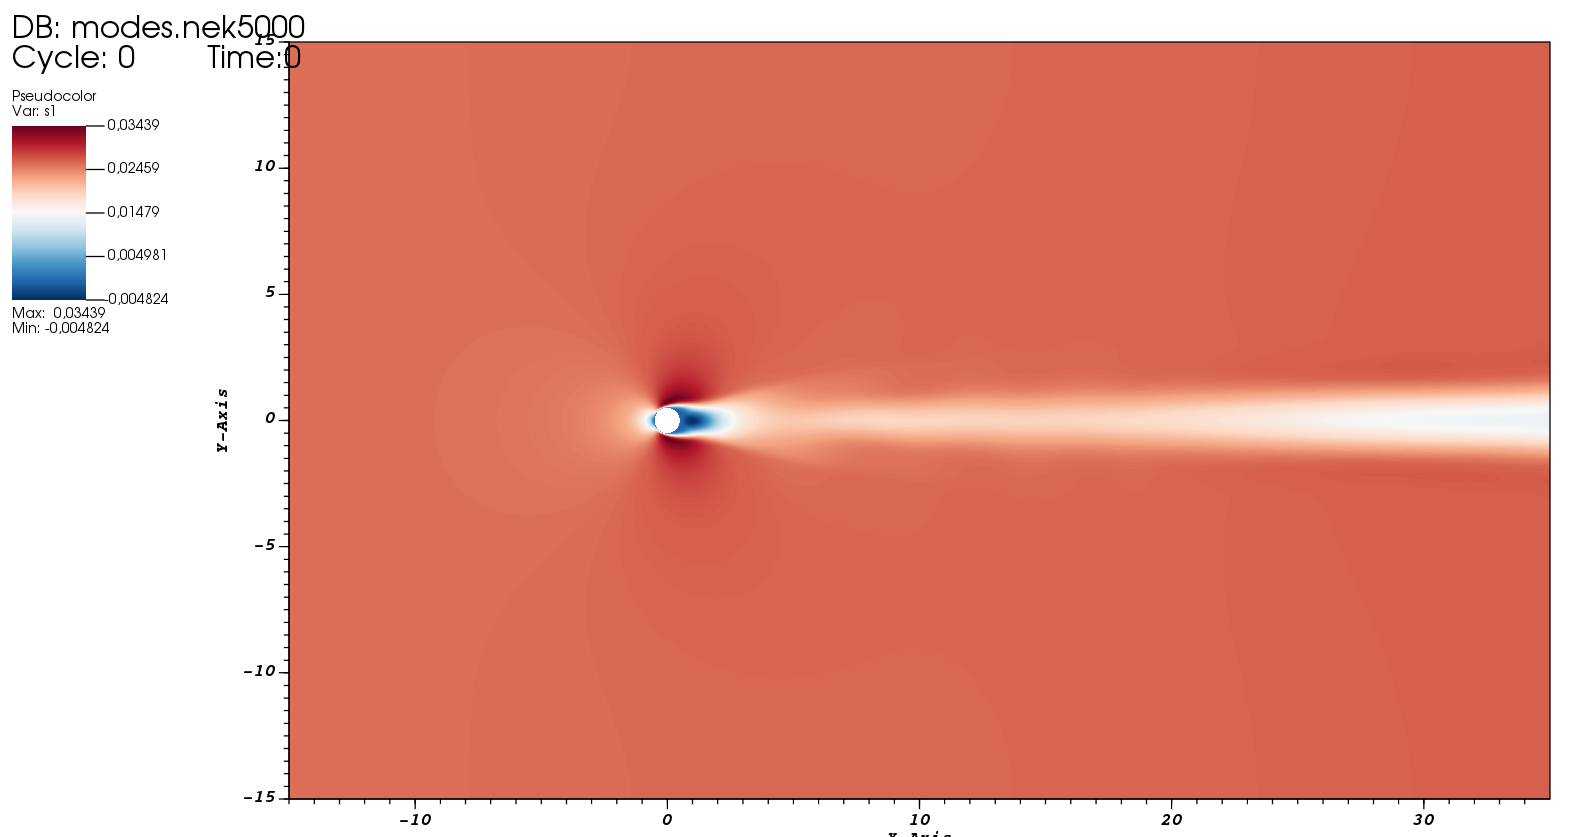


Mode 1:

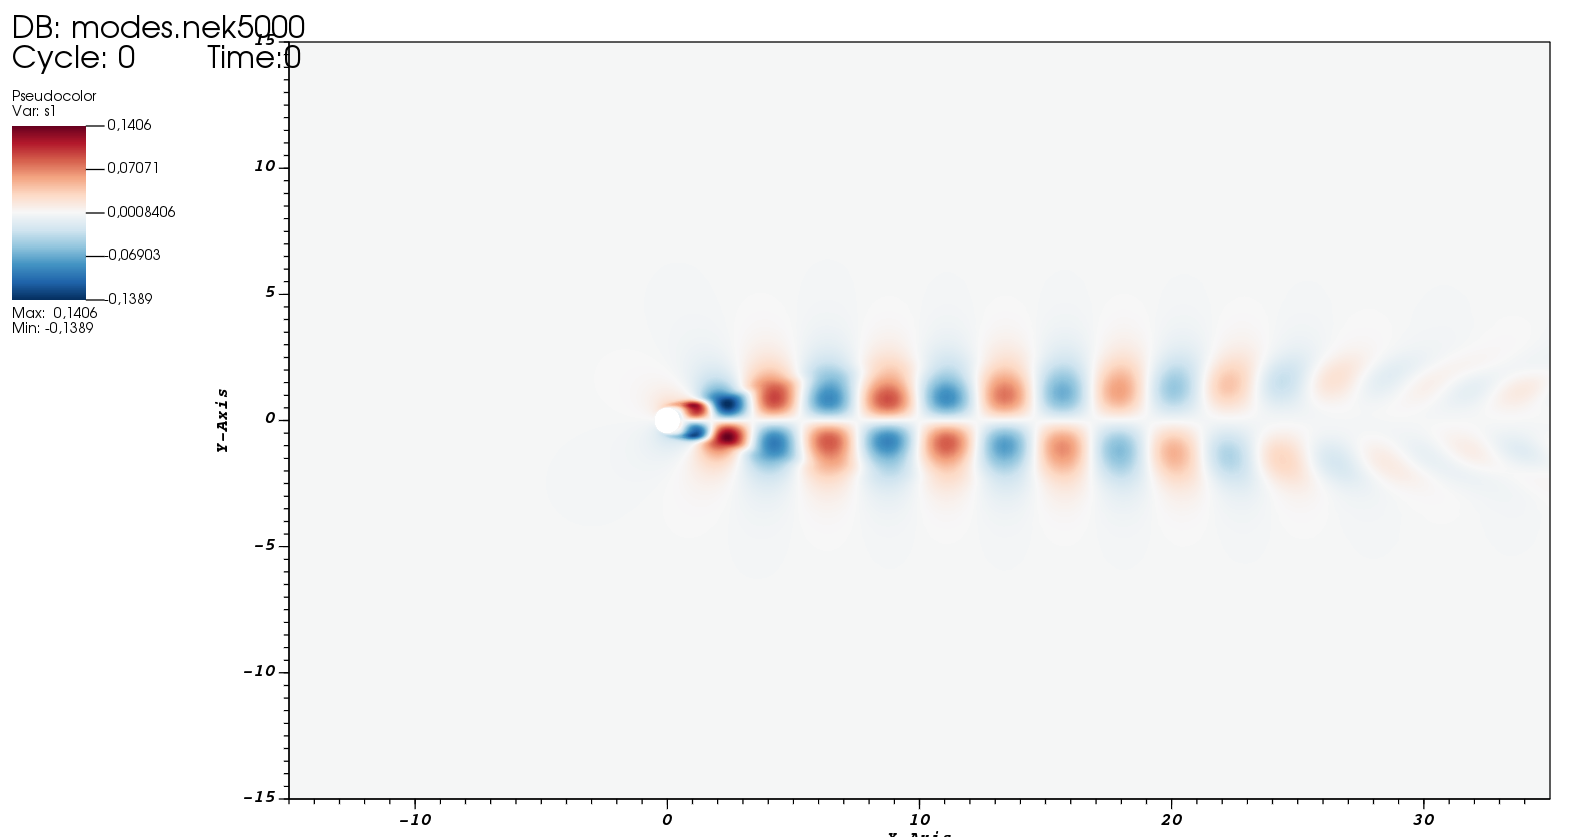

Mode 2:

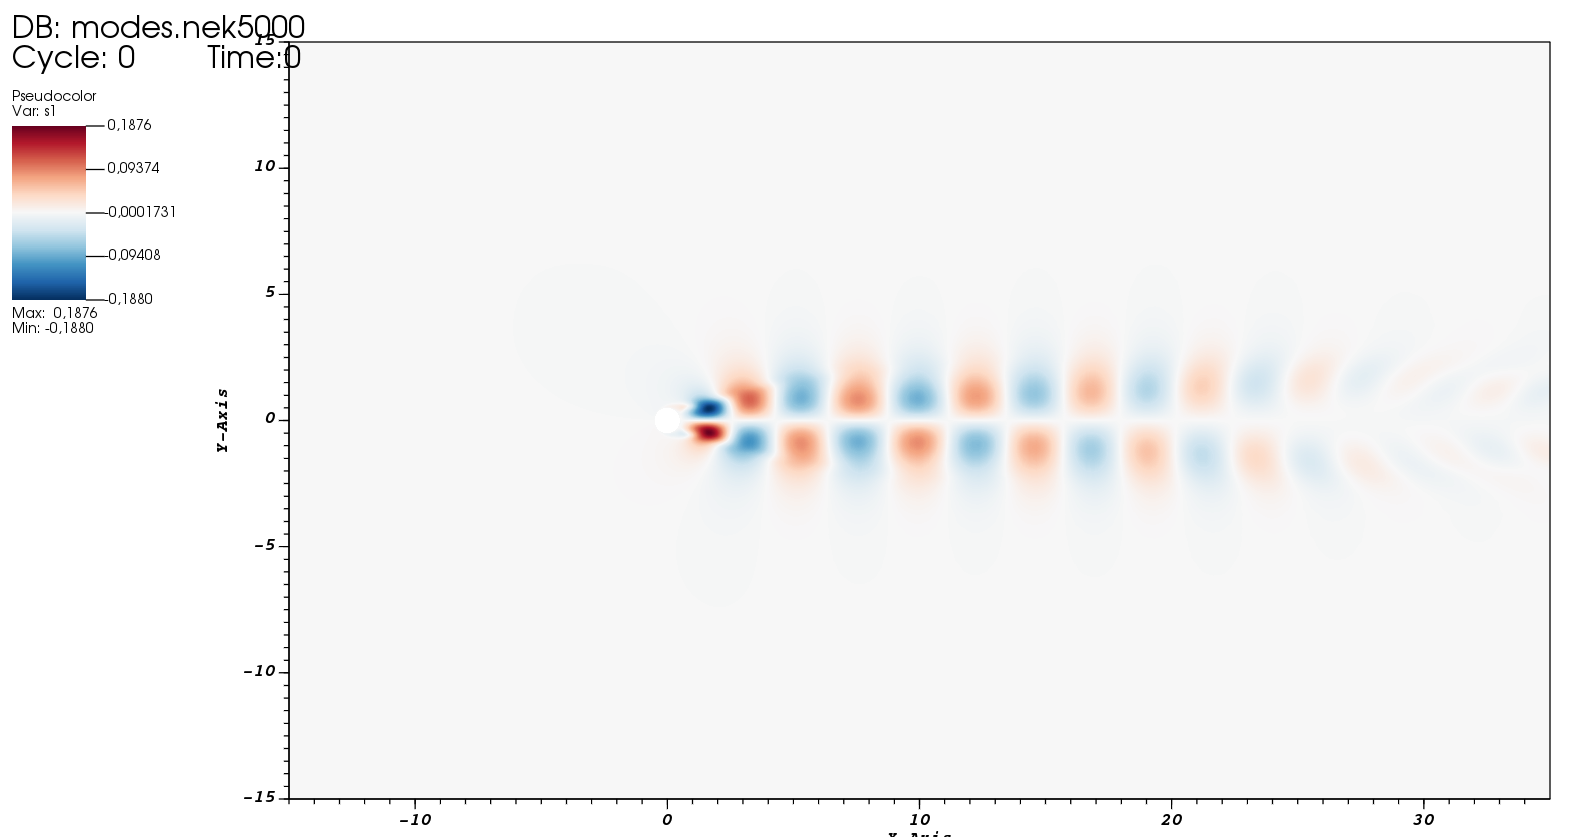

## Singular values:

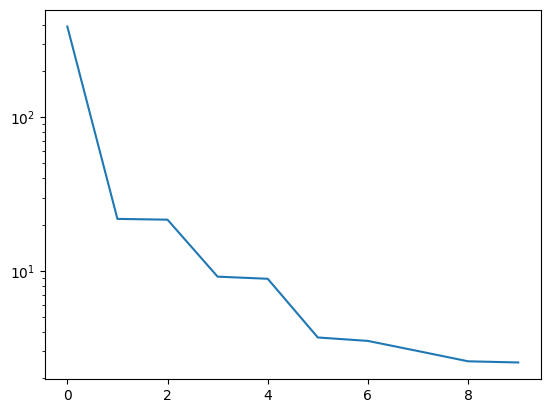

In [15]:
import matplotlib.pyplot as plt

d = np.load("singular_values.npy")

plt.semilogy(d)
plt.show()

Note how mode 0 has the larger energy, and represents the mean. Afterwards, modes come in pairs of energy, representing traveling waves.

## Time coefficients

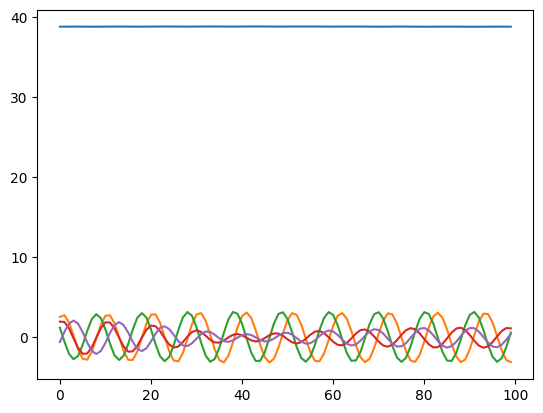

In [17]:
vt = np.load("right_singular_vectors.npy")
T = np.diag(d)@vt

plt.plot(T[0,:])
plt.plot(T[1,:])
plt.plot(T[2,:])
plt.plot(T[3,:])
plt.plot(T[4,:])
plt.show()

See here how the mode 0 represents the mean flow. And how the paired modes are shifted by a phase of 90 degrees and serve to represent the travelling nature of the wave